In [1]:
import os 
import mlflow as mf 
import joblib
import torch
import transformers
import numpy as np
from tqdm import tqdm

import ftzard.utils.mlflow as mf_utils
from ftzard.utils.dvc import get_current_date_time



from hydra import initialize, compose
from warnings import filterwarnings
import matplotlib.pyplot as plt

import dagstermill as dgm
filterwarnings("ignore")

/app/.pixi/envs/default/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
base_path = '/app/ftzard'
config_path = f'{base_path}/config/'
try:
    os.symlink(config_path, "config_link")
except Exception as e:
    print("Symlink already created...")
config_name = 'config'

Symlink already created...


In [3]:
with initialize(version_base=None, config_path="config_link"):
    cfg = compose(config_name=config_name)
    tracking_uri, experiment_name = cfg.MLFLOW.TRACKING.URI, cfg.MLFLOW.EXPERIMENT.NAME
    mlflow_model_name = cfg.MLFLOW.MODEL.NAME 
    

In [4]:
os.environ['MLFLOW_TRACKING_URI'] = tracking_uri
base_run_name = 'DATA_SAMPLING'
run_name = get_current_date_time()
data_path = f"{base_path}/data/preidictions_logits.joblib"
print("Base Run Name: ", base_run_name )
print('Mlflow Experiment Name: ', experiment_name)
print('Mlflow Run Name: ', run_name)
print('Path to Data: ', data_path)

Base Run Name:  DATA_SAMPLING
Mlflow Experiment Name:  senetiment_analysis
Mlflow Run Name:  2024-07-02_12:7
Path to Data:  /app/ftzard/data/preidictions_logits.joblib


In [5]:
predictions_data = joblib.load(data_path)

INFO:datasets:PyTorch version 2.0.1 available.


In [6]:
print(predictions_data.keys())

dict_keys(['data', 'predicted_labels', 'logits'])


In [7]:
logits = predictions_data["logits"]
logits = np.array(logits)
print(logits.shape, logits[0])

(480, 2) [-4.766 -9.06 ]


In [8]:
def softmax(array):
    exponents, result  = np.zeros(array.shape), np.zeros(array.shape)
    for index in range(len(array)):
        exponents[index] = np.exp(array[index])
    for index in range(len(array)):
        result[index] = exponents[index]/np.sum(exponents)

    return result

def least_confidence_sampling(array):
    return (1 - np.max(array))/(len(array)/(len(array)-1))
    
        

softmax_logits = np.array([softmax(elem) for elem in logits])
print('Softmax Logits: \n', softmax_logits[:3])


uncertainity_scores = np.array([least_confidence_sampling(item) for item in softmax_logits])
print('Uncertainity Scores: \n', uncertainity_scores[:3])

Softmax Logits: 
 [[0.98656703 0.01343297]
 [0.96789367 0.03210633]
 [0.4044814  0.5955186 ]]
Uncertainity Scores: 
 [0.00671648 0.01605316 0.2022407 ]


In [9]:
range_of_uncertainity = [np.min(uncertainity_scores), np.max(uncertainity_scores)]
print('Range of Uncertainity Scores: ', range_of_uncertainity)
print('Maximum Uncertainity Score', 0.5)

Range of Uncertainity Scores:  [0.00027729646909163685, 0.249490538573508]
Maximum Uncertainity Score 0.5


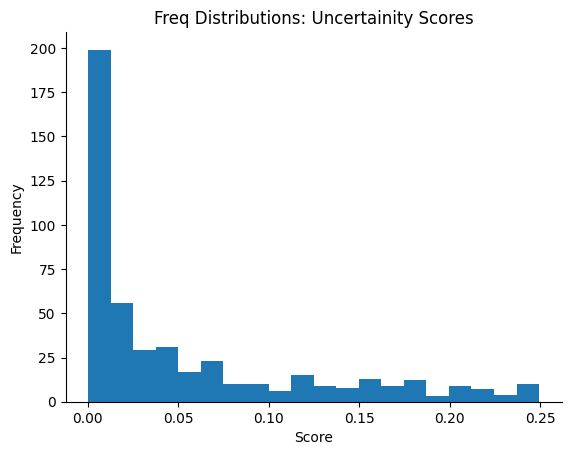

In [10]:
plt.hist(uncertainity_scores, bins=20)
plt.title("Freq Distributions: Uncertainity Scores")
plt.ylabel("Frequency")
plt.xlabel("Score")
plt.gca().spines["top"].set_visible(0)
plt.gca().spines["right"].set_visible(0)
plt.show()

In [11]:
threshold = np.quantile(uncertainity_scores, .75)
print("Sampling Threshold: ", threshold)

Sampling Threshold:  0.08102927950993387


In [12]:
top_uncertain_indices = np.where(uncertainity_scores>=threshold)

In [13]:
experiment_name

'senetiment_analysis'

In [15]:
experiment_id = mf_utils.create_experiment(exp_name=experiment_name)

base_run_id = mf_utils.get_run_id_by_name(run_name=base_run_name, 
                                             experiment_ids=[experiment_id])

with mf.start_run(run_name=base_run_name, run_id = base_run_id, experiment_id=experiment_id):
    run_id = mf_utils.get_run_id_by_name(run_name=run_name, 
                                    experiment_ids=[experiment_id], 
                                    nested=True)
    with mf.start_run(run_name=run_name, run_id = run_id, experiment_id=experiment_id,
                     nested=True):
        try:
            mf.log_param("min_uncert", range_of_uncertainity[0])
            mf.log_param("max_uncert", range_of_uncertainity[0])
            mf.log_param("threshold", threshold)
        except Exception as e:
            print(e)

The provided experiment name senetiment_analysis already exists, the run will be logged in this experiment.
                                 


In [16]:
top_uncertain_data = predictions_data["data"].select(top_uncertain_indices[0])
print(top_uncertain_data)

Dataset({
    features: ['label', 'input_ids', 'attention_mask'],
    num_rows: 120
})


In [17]:
metadata = {"run_name": run_name,
           "run_id":run_id,
           "base_run_id": base_run_id,
           "base_run_name": base_run_name}

In [18]:
outputs = {
    "data": top_uncertain_data
}

In [19]:
dgm.yield_result(outputs, output_name="retraining_data")
dgm.yield_result(metadata, output_name='step6_run_metadata')

{'run_name': '2024-07-02_12:7',
 'run_id': 'd128fa2f49714da18363f3511fbd8eb8',
 'base_run_id': '7e293d885146454991da53fdd44793cf',
 'base_run_name': 'DATA_SAMPLING'}